In [4]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [23]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [6]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    print(image)
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]




$$\mbox{Output} = w^Tx_c=w^Tx+w^T\eta$$
, $w$: trained weights and $x$: input and $x_c$: modified input $\eta$: shifting values




$$\mbox{sign}(\eta)=\mbox{ sign }(\nabla_x J(\theta,x,y)) $$
$$ $$
, with $J$: cost function of the NN, $\theta$: trained weights, $x$: inputs and $y$: labels

In [7]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image,steps=1)

Tensor("truediv_1:0", shape=(?, ?, ?), dtype=float32)


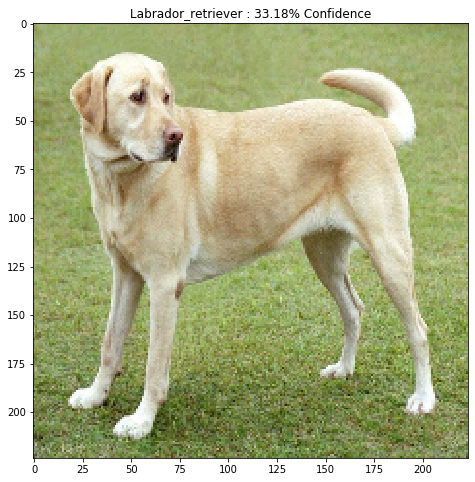

In [12]:
sess = tf.Session()
with sess.as_default():
    plt.figure()
    plt.imshow(image.eval()[0])
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tf.gradients(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [14]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


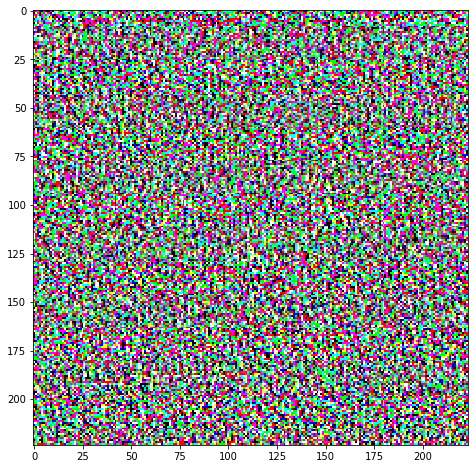

In [31]:
init = tf.global_variables_initializer()
sess.run(init)
plt.imshow(tf.reshape(perturbations,[224,224,3]).eval(session=sess))
plt.show()

In [36]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image[0],steps=1))
    plt.figure()
    print(image[0])
    plt.imshow(image[0].eval(session=sess)[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

Tensor("strided_slice_15:0", shape=(1, 224, 224, 3), dtype=float32)


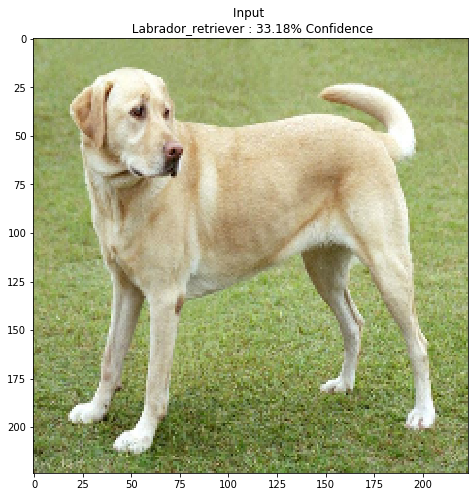

Tensor("strided_slice_18:0", shape=(1, 224, 224, 3), dtype=float32)


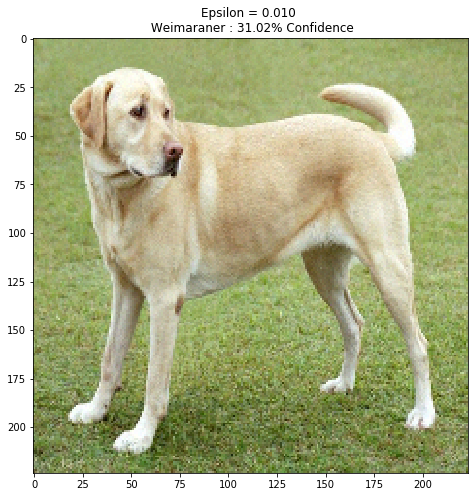

Tensor("strided_slice_21:0", shape=(1, 224, 224, 3), dtype=float32)


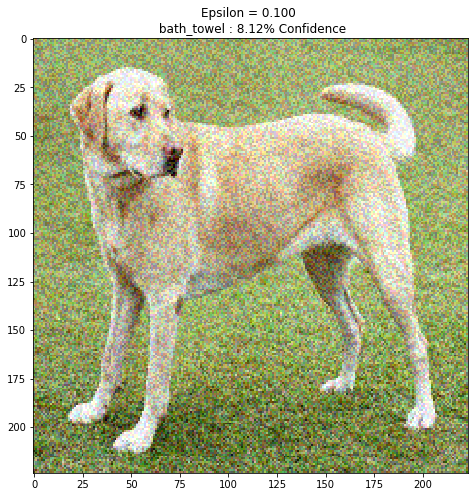

Tensor("strided_slice_24:0", shape=(1, 224, 224, 3), dtype=float32)


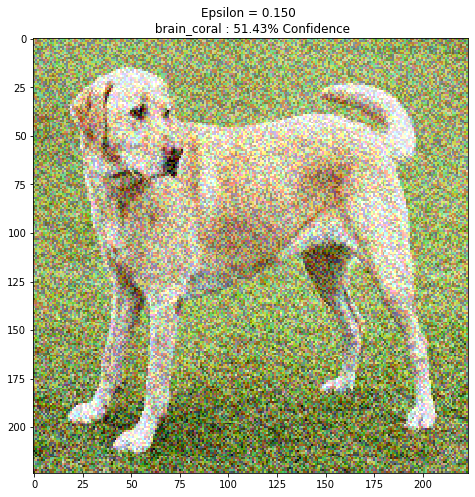

In [37]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])